# Analizando compras

👋 En esta jupyter vamos a analizar a los clientes y sus compras referidas a **barras de chocolate**.

La idea es tomar datos nuevos y segmentarlos en base a los segmentos que encontramos anteriormente. Luego intentaremos predecir qué marca de chocolate comprará la persona y qué cantidad.

Utilizaremos los modelos *StandardScaler*, *PCA* y *KMeans* entrenados previamente.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
sns.set() #seteamos sns como estilo por defecto

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
## cargamos los datos
df_compras = pd.read_csv("datasets/purchase_data.csv")

In [3]:
df_compras.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,200000001,1,0,0,0,0,0,1.59,1.87,2.01,...,0,0,0,0,0,47,1,110866,1,0
1,200000001,11,0,0,0,0,0,1.51,1.89,1.99,...,0,0,0,0,0,47,1,110866,1,0
2,200000001,12,0,0,0,0,0,1.51,1.89,1.99,...,0,0,0,0,0,47,1,110866,1,0
3,200000001,16,0,0,0,0,0,1.52,1.89,1.98,...,0,0,0,0,0,47,1,110866,1,0
4,200000001,18,0,0,0,0,0,1.52,1.89,1.99,...,0,0,0,0,0,47,1,110866,1,0


### Analizando columnas

- *Incidence*: Hace referencia a si la persona compró algún ítem de la categoría (1) o no (0).
- *Brand*: Marca de chocolate (de 1 a 5).
- *Quantity*: Cantidad comprada.
- *Last_Inc_Brand*: Muestra que marca compró en su última visita el cliente (de 1 a 5).
- *Last_Inc_Quantity*: Muestra la cantidad de chocolate que compro en su última visita.

- *Promotions*: Hace referencia a si se aplicaron o no promociones sobre la compra del cliente.
- *Datos demográficos*: Las últimas 7 características (columnas) representan los datos demográficos analizados anteriormente.

In [4]:
# df_compras.isnull().sum()

Podemos ver que no tenemos valores nulos en nuestro set de datos.

### Segmentando clientes nuevos

Debemos notar que las últimas 7 columnas poseen la misma información que hemos utilizado anteriormente para segmentar los clientes. De hecho, utilizaremos estas columnas y los modelos guardados para segmentarlos.

In [5]:
## cargamos modelos

scaler = pickle.load(open("models/scaler.pickle","rb"))
pca = pickle.load(open("models/pca.pickle","rb"))
kmeans_pca = pickle.load(open("models/kmeans_pca.pickle", "rb"))

#### Estandarizando, aplicando PCA y segmentando

Ahora vamos a aplicar el PCA entrenado a los datos correspondientes a las últimas siete columnas del dataframe que hemos cargado. Luego aplicaremos estos datos transformados al modelo Kmeans para segmentar los clientes. Antes debemos aplicar el *scaler* a los datos.

In [6]:
## nos quedamos con las columnas para procesar los segmentos
segmentos_features = df_compras[["Sex", "Marital status","Age", "Education", "Income", "Occupation","Settlement size"]]

In [7]:
## Estandarizamos los datos
df_compras_std = scaler.transform(segmentos_features)

In [8]:
## Aplicamos PCA
df_compras_std_pca = pca.transform(df_compras_std)

In [9]:
## Segmentamos los clientes usando KMeans
labels_segmentos = kmeans_pca.predict(df_compras_std_pca)

In [10]:
df_compras_segmentados = df_compras.copy() #predictors

In [11]:
#Agregamos una columna con los segmentos encontrados por KMeans
df_compras_segmentados["Segmento"] = labels_segmentos

#### Guardando dataframe con segmentos

A continuación guardaremos el dataframe con los segmentos encontrados para poder usarlo más adelante.

In [12]:
df_compras_segmentados.to_csv("datasets/purchase_data_segmentado.csv", index = False)

## Análisis *descriptivo* de los segmentos

### Análisis de datos por *cliente*

Analizaremos que tan seguido cada grupo va de compras, cuánto dinero gastan y que productos compraron.

Debemos notar que tenemos varias compras por individuo. La idea es poder obtener un resumen o *summary* de cada cliente, para así poder estudiar a cada cliente de manera individual. Vamos a generar un nuevo dataframe que contenga información resumida de cada cliente.

In [13]:
#Contabilizamos la cantidad de veces que un cliente entro a la tienda
temporal1 = df_compras_segmentados[["ID","Incidence"]].groupby(["ID"], as_index = False).count()
temporal1 = temporal1.set_index("ID")
temporal1 = temporal1.rename(columns = {"Incidence": "N. visitas"})

In [14]:
temporal1.head()

,N. visitas
ID,
200000001,101
200000002,87
200000003,97
200000004,85
200000005,111


#### Cantidad de veces que un cliente compró un producto

Estamos interesados en saber las veces que un cliente ha comprado un producto al entrar a la tienda. Esto nos servirá como un indicador de la probabilidad de que cuando ingrese a la tienda, compre un producto, y además, si comprará o no un chocolate, eventualmente qué marca comprará y finalmente en qué cantidad.

La columna **incidence** posee el valor $1$ si hubo una compra de algúna barra de chocolate o $0$ en otro caso.

Por lo tanto, para saber la cantidad de veces que un cliente ha comprado un chocolate, lo único que tenemos que hacer es sumar la columna.

In [15]:
temporal2 = df_compras_segmentados[["ID","Incidence"]].groupby("ID",as_index = False).sum()
temporal2 = temporal2.set_index("ID")
temporal2 = temporal2.rename(columns = {"Incidence":"N. compras"})

In [16]:
temporal2.head()

,N. compras
ID,
200000001,9
200000002,11
200000003,10
200000004,11
200000005,13


In [17]:
## combinamos ambos dataframes
temporal3 = temporal1.join(temporal2)
temporal3.head()

,N. visitas,N. compras
ID,,
200000001,101,9
200000002,87,11
200000003,97,10
200000004,85,11
200000005,111,13


Ahora tenemos un nuevo dataframe que posee la cantidad de veces que un cliente ha visitado la tienda y el número de compras realizado en esas visitas.

##### Frecuencia promedio de compra por cada cliente

Esto es sencillo de calcular ya que es la cantidad de veces que el cliente compró chocolate divido las veces que entro a la tienda.

In [18]:
temporal3["Frec_prom_compra"] = temporal3["N. compras"]/temporal3["N. visitas"]
temporal3.head()

,N. visitas,N. compras,Frec_prom_compra
ID,,,
200000001,101,9,0.089109
200000002,87,11,0.126437
200000003,97,10,0.103093
200000004,85,11,0.129412
200000005,111,13,0.117117


Ahora agregaremos una columna para saber a qué segmento (que hemos predicho con KMeans y PCA) pertenece cada cliente.

In [19]:
temporal4 = df_compras_segmentados[["ID","Segmento"]].groupby("ID",as_index = False).mean().astype('int')
temporal4 = temporal4.set_index("ID")
df_compra_cliente = temporal3.join(temporal4)
df_compra_cliente.head()

,N. visitas,N. compras,Frec_prom_compra,Segmento
ID,,,,
200000001,101,9,0.089109,2
200000002,87,11,0.126437,3
200000003,97,10,0.103093,2
200000004,85,11,0.129412,2
200000005,111,13,0.117117,1


### Analizando proporciones de los segmentos

Podríamos poder analizar el comportamiento de cada cliente. No obstante, tenemos pocos datos.

Lo que podemos hacer es estudiar a cada segmento.

Calculemos las **proporciones de compra por segmento**.

In [20]:
propor_segmen = df_compra_cliente[["N. compras", "Segmento"]].groupby("Segmento").count()/df_compra_cliente.shape[0]
propor_segmen = propor_segmen.rename(columns = {"N. compras":"Proporciones Segmento"})
propor_segmen

,Proporciones Segmento
Segmento,
0,0.206
1,0.220
2,0.378
3,0.196


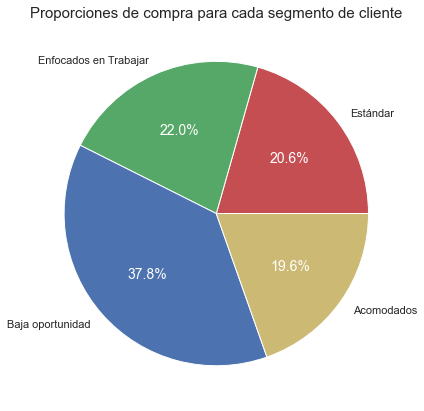

In [21]:
plt.figure(figsize = (10,7))
_, _, autotexts = plt.pie(propor_segmen["Proporciones Segmento"],
                            labels = ["Estándar", "Enfocados en Trabajar", "Baja oportunidad", "Acomodados"],
                            autopct = "%1.1f%%",
                             colors = ("r","g","b","y"))

for ins in autotexts:
    ins.set_color('white')
    ins.set_fontsize(14)
    
plt.title("Proporciones de compra para cada segmento de cliente", fontsize = 15)
plt.show()

#### Frecuencia de visitas por segmento

Vamos a ver,

- cuan a menudo las personas de un segmento visitan la tienda,
- cuan a menudo compran barras de chocolate,
- cuan seguido compran relativo al número de visitas.

Para poder responder esto, vamos a encontrar los valores medios y los desvíos estándard *por segmento* de nuestro dataframe. La *media* muestra el *comportamiento* de cada segmento. Por otro lado, el desvío estándar muestra que tan *homogeneo* cada segmento es.

In [22]:
media_segmentos = df_compra_cliente.groupby(["Segmento"]).mean()
media_segmentos = media_segmentos.rename({0: "Estándar",
                                          1: "Enfocados en trabajar",
                                          2: "Baja oportunidad",
                                          3: "Acomodados"})
media_segmentos

,N. visitas,N. compras,Frec_prom_compra
Segmento,,,
Estándar,117.699029,24.902913,0.212773
Enfocados en trabajar,123.454545,39.827273,0.283102
Baja oportunidad,113.730159,22.756614,0.201588
Acomodados,117.295918,34.602041,0.284478


In [23]:
## encontramos el desvío estandar
std_segmentos = df_compra_cliente.groupby(["Segmento"]).std()
std_segmentos = std_segmentos.rename({0: "Estándar",
                                      1: "Enfocados en trabajar",
                                      2: "Baja oportunidad",
                                      3: "Acomodados"})
std_segmentos

,N. visitas,N. compras,Frec_prom_compra
Segmento,,,
Estándar,19.039605,16.774464,0.126603
Enfocados en trabajar,44.864656,53.744530,0.200056
Baja oportunidad,16.410498,13.815040,0.120335
Acomodados,20.716152,25.900579,0.171787


##### Frecuencia de personas en cada segmento visitando la tienda

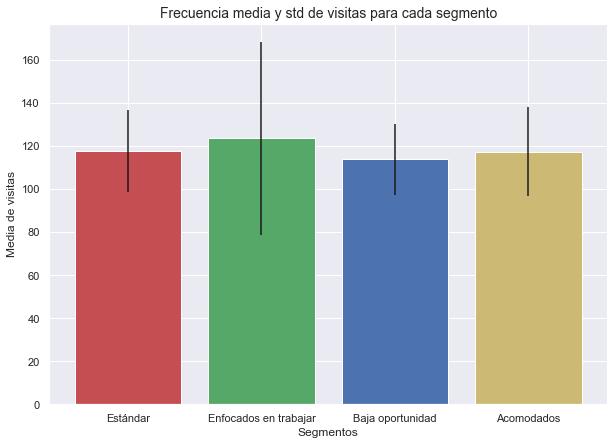

In [24]:
plt.figure(figsize = (10,7))

plt.title("Frecuencia media y std de visitas para cada segmento", fontsize = 14)
plt.bar(x = range(0,4), tick_label = ("Estándar","Enfocados en trabajar","Baja oportunidad","Acomodados"),
       height = media_segmentos["N. visitas"], yerr = std_segmentos["N. visitas"],
       color = ("r","g","b","y"))
plt.xlabel("Segmentos")
plt.ylabel("Media de visitas")

plt.show()

##### Frecuencia de compras por segmento

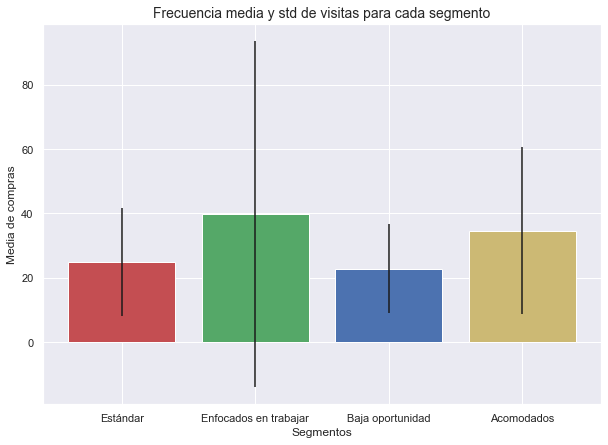

In [25]:
plt.figure(figsize = (10,7))

plt.title("Frecuencia media y std de visitas para cada segmento", fontsize = 14)
plt.bar(x = range(0,4), tick_label = ("Estándar","Enfocados en trabajar","Baja oportunidad","Acomodados"),
       height = media_segmentos["N. compras"], yerr = std_segmentos["N. compras"],
       color = ("r","g","b","y"))
plt.xlabel("Segmentos")
plt.ylabel("Media de compras")

plt.show()

Podemos ver que las personas que están dentro del segmento estándar son las que más compras realizan. No obstante, su desvío estándar es elevado. Esto puede ser debido a que un grupo de personas dentro de este segmento compra muy a menudo y otro grupo compra con mucho menos frecuencia, o bien, la forma de gastar el dinero es diferente entre estas personas dentro del segmento.

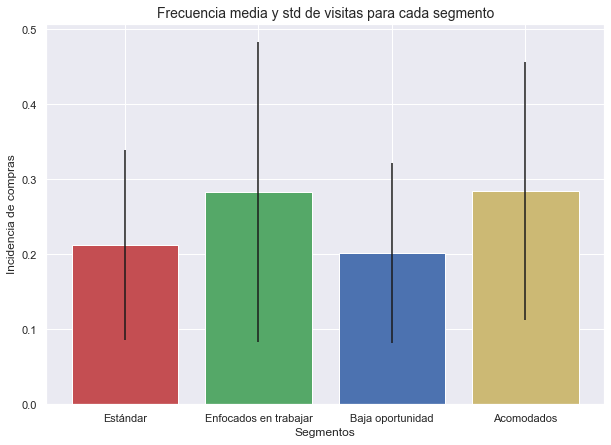

In [26]:
## Número promedio de compras por segmento
plt.figure(figsize = (10,7))

plt.title("Frecuencia media y std de visitas para cada segmento", fontsize = 14)
plt.bar(x = range(0,4), tick_label = ("Estándar","Enfocados en trabajar","Baja oportunidad","Acomodados"),
       height = media_segmentos["Frec_prom_compra"], yerr = std_segmentos["Frec_prom_compra"],
       color = ("r","g","b","y"))
plt.xlabel("Segmentos")
plt.ylabel("Incidencia de compras")

plt.show()

### Selección de marcas por segmento

Vamos a analizar las preferencias de cada marca por segmento.

La columna *incidence* es la que nos dice si un cliente compró o no un chocolate, por lo tanto, filtraremos el dataset cuando *incidence == 1*.

Además, deberemos generar *dummy variables* correspondiente a cada una de las 5 marcas de chocolote que tenemos. Recordemos que estas dummies nos permiten formar una matriz en donde tendremos ceros en todas las marcas que no se corresponden al chocolate comprado y un uno al chocolate comprado.

In [27]:
df_compras_incidencia = df_compras_segmentados[df_compras_segmentados["Incidence"] == 1] 

In [28]:
dummies_marcas = pd.get_dummies(df_compras_incidencia["Brand"], prefix = "Marca", prefix_sep = "_")
dummies_marcas["Segmento"], dummies_marcas["ID"] = df_compras_incidencia["Segmento"], df_compras_incidencia["ID"]

In [29]:
# dummies_marcas.head()

In [30]:
temp = dummies_marcas.groupby(["ID"], as_index = True).mean()
# temp.head()

**NOTA**: Cuando agrupamos por ID y seteamos los ID como índices lo que hacemos es obtener **cuanto en promedio un cliente elige cierta marca**.

Haremos algo similar pero por segmentos.

In [31]:
promedio_marca_elegidas_segmentos = temp.groupby(["Segmento"], as_index = True).mean()
promedio_marca_elegidas_segmentos

,Marca_1,Marca_2,Marca_3,Marca_4,Marca_5
Segmento,,,,,
0.0,0.251186,0.396502,0.156481,0.059474,0.136357
1.0,0.072871,0.146808,0.039976,0.112395,0.627951
2.0,0.137567,0.681190,0.020923,0.061548,0.098772
3.0,0.041928,0.117422,0.030610,0.613623,0.196417


#### Heatmap

Crearemos un **heatmap** para ver las preferencias de marcas para cada segmento.

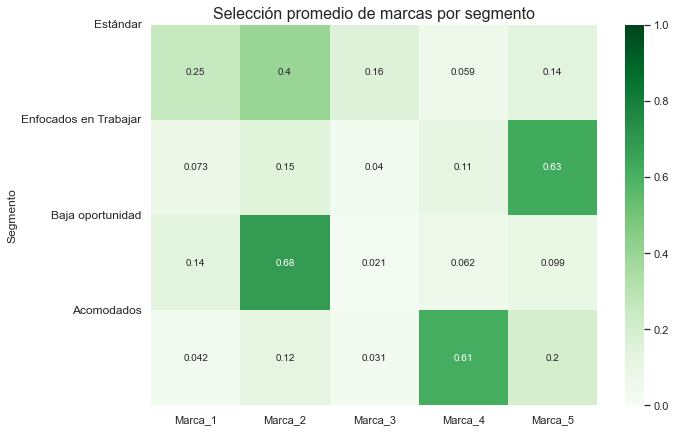

In [32]:
plt.figure(figsize = (10,7))

sns.heatmap(promedio_marca_elegidas_segmentos, vmin = 0, vmax = 1,
           cmap = "Greens", annot = True)

plt.yticks([0,1,2,3], ["Estándar","Enfocados en Trabajar","Baja oportunidad","Acomodados"],
           rotation = 0, fontsize = 12)
plt.title("Selección promedio de marcas por segmento", fontsize = 16)
plt.show()

Los valores que vemos dentro del *heatmap* corresponden a las **proporciones promedio de marcas selecionadas por cada segmento**.

Es importante tener en cuenta que las marcas van de *más barata a más cara*.

**Análisis**

- El segmento *Baja oportunidad* evidentemente tiene una fuerte inclinación por la marca dos, casi el 70% de las personas dentro de este segmento elige la marca 2. Ahora bien, la marca 2 no es la más barata, lo que nos da la pauta de que a pesar de ser un segmento de oportunidades bajas, no siempre se inclinan por el producto barato.
- Las personas dentro del segmento *estándar* tienen preferencia por la marca 2, y en menor medida por la 1 y la 3. Claramente no compran la marca 4.
- El segmento de *acomodados* disfruta de marcas caras, pero no de la más cara. Tal vez para este grupo se enfoca en darse gustos en otros productos y/o son un poco más austeros.
- Las personas dentro de *enfocados en trabajar* claramente tienen una predisposición por comprar la Marca 5, la cual es la más cara. Podríamos pensar que disfrutan de darse un "*lujo*". ¿Es posible aumentar el precio de esta marca un poco y aún mantener una proporción de compra similar en este segmento? Si esto es posible, entonces podríamos estar en una oportunidad de aumentar ganancias.

Ahora bien, esta forma de analizar los datos no nos dice nada acerca de cómo estas preferencias afectan las ganancias. Por lo tanto, analicemos cuanta ganancia obtenemos por segmento.

## Ganancias por segmentos

Ahora vamos a realizar un **análisis exploratorio** de las ganancias por cada marca de barra de chocolate.

Para esto, voy a generar un nuevo dataframe que contenga las ganancias por cada segmento. Agregaremos una columna con las proporciones totales vendidas por cada segmento.

El cálculo de ganancia es simplemente 

$$ Ganancia_{marca}= Cantidad_{barras~vendidas} \times Precio_{barra}$$

In [33]:
df_marca1 = df_compras_segmentados[df_compras_segmentados["Brand"]==1][["ID","Incidence","Quantity","Price_1","Segmento"]]
df_marca1.loc[:, "Ganancia Marca 1"] = df_marca1["Price_1"]*df_marca1["Quantity"] 
df_ganancias = pd.DataFrame()

df_ganancias[["Segmento","Ganancia Marca 1"]] = df_marca1[["Segmento","Ganancia Marca 1"]].groupby(["Segmento"], as_index = False).sum()
df_ganancias


,Segmento,Ganancia Marca 1
0,0,2611.19
1,1,736.09
2,2,2258.90
3,3,699.47


In [34]:
marcas = df_compras_segmentados["Brand"].unique()
marcas.sort()
marcas = marcas[1:]

df_ganancias = pd.DataFrame()

filtro1 = df_compras_segmentados["Brand"] == 1
filtro2 = df_compras_segmentados["Incidence"] == 1

for marca in marcas:
    filtro1 = df_compras_segmentados["Brand"] == marca
    temp = df_compras_segmentados[filtro1&filtro2][["ID","Incidence","Quantity",f"Price_{marca}","Segmento"]]
    temp.loc[:, f"Ganancia Marca {marca}"] = temp[f"Price_{marca}"]*temp["Quantity"]
    df_ganancias[["Segmento",f"Ganancia Marca {marca}"]] = temp[["Segmento",f"Ganancia Marca {marca}"]].groupby(["Segmento"], as_index = False).sum()


#Agrego columna de ventas totales y proporciones vendidas por cada segmento
df_ganancias["Ganancias totales"] = df_ganancias.iloc[:,1:].sum(axis = 1)
# df_ganancias["Proporciones"] = df_ganancias.iloc[:,1:].sum(axis = 1)/df_ganancias.iloc[:,1:].sum(axis = 1).sum()
df_ganancias["Proporciones Segmento"] = propor_segmen["Proporciones Segmento"]
#seteamos los ínidices

df_ganancias = df_ganancias.set_index(["Segmento"]).rename({0: "Estándar",
                                                          1: "Enfocados en trabajar",
                                                          2: "Baja oportunidad",
                                                          3: "Acomodados"})

In [35]:
df_ganancias

,Ganancia Marca 1,Ganancia Marca 2,Ganancia Marca 3,Ganancia Marca 4,Ganancia Marca 5,Ganancias totales,Proporciones Segmento
Segmento,,,,,,,
Estándar,2611.19,4768.52,3909.17,861.38,2439.75,14590.01,0.206
Enfocados en trabajar,736.09,1746.42,664.75,2363.84,19441.06,24952.16,0.220
Baja oportunidad,2258.90,13955.14,716.25,1629.31,2230.50,20790.10,0.378
Acomodados,699.47,1298.23,731.35,14185.57,5509.69,22424.31,0.196


#### Analizando resultados

El segmento *enfocados en trabajar* es el que más dinero ha gastado en la compra de barras de chocolate. Le siguen los segmentos *acomodados* y *baja oportunidad*. Por detrás viene el segmento de *estándar*.

Ahora bien, recordemos que la columna *Proporciones por Segmento* hacen referencia a la proporción de compra que cada segmento realiza en barras de chocolate. Podemos ver que el segmento enfocado en trabajar, es el que más gasta (compran la marca más cara) y además, está en segundo lugar en cuanto a proporción de compra respecto a los otros segmentos.

El segmento *estándar* es el que menos gasta, a pesar de que la proporción de compras esta en el tercer lugar. Evidentemente este segmento es el que menos contribuye en las ganancias de ventas de chocolate.

Ahora bien, las personas dentro de los segmentos *baja oportunidad* y *acomodados* gastan practicamente lo mismo, pero debemos notar que el segmento de baja oportunidad prácticamente dobla en proporción de veces que compra barras de chocolate.